In [1]:
import tensorflow as tf

# Building blocks

In [2]:
"""Tensorflow-Keras Implementation of Mish"""
# Took from this https://gist.github.com/ypeleg/3af35d07d7f659f387952c9843849772
## Import Necessary Modules
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'mish': Mish(mish)})

In [3]:
''' 
Build the blocks required for resnet, uses 2 blocks:
1) Identity block 
2) Convolutional block
'''
def identity_block(X, f, filters, stage, block):
    '''
    Implementation of an identity block 
    
    Args:
        X(input_tensor) : input tensor of shape (m, n_h_prev, n_w_prev, n_c_prev)
        f(int): this is to specify the kernel size or window for the main path within the identiy block
        filters(list): list of integers to define for the Conv layers of the main path
        stage(int): use to name the layers depending of their position
        block(str): used to name layer, depending on their position in the network
        
    Returns:
        X(tensor): output of the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    
    # Start by defining name base
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = tf.keras.layers.Conv2D(
        filters=F1, kernel_size=(1, 1), strides=(1,1), padding='valid',
        name=conv_name_base + '2a'
    )(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = tf.keras.layers.Activation('mish')(X)
    
    # Second component of main path
    X = tf.keras.layers.Conv2D(
        filters=F2, kernel_size=(f, f), strides = (1,1), padding = 'same',
        name = conv_name_base + '2b'
    )(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = tf.keras.layers.Activation('mish')(X)
    
    # Third component of main path
    X = tf.keras.layers.Conv2D(
        filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
        name = conv_name_base + '2c'
    )(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('mish')(X)
    
    return X

In [4]:
def convolutional_block(X, f, filters, stage, block, s=2):
    '''
    Implementation of an identity block 
    
    Args:
        X(input_tensor) : input tensor of shape (m, n_h_prev, n_w_prev, n_c_prev)
        f(int): this is to specify the kernel size or window for the main path within the identiy block
        filters(list): list of integers to define for the Conv layers of the main path
        stage(int): use to name the layers depending of their position
        block(str): used to name layer, depending on their position in the network
        s(int): The stride to be used
        
    Returns:
        X(tensor): output of the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    
    # Start by defining name base
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = tf.keras.layers.Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a')(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name = bn_name_base + '2a')(X)
    X = tf.keras.layers.Activation('mish')(X)
    
    # Second component of main path
    X = tf.keras.layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = tf.keras.layers.Activation('mish')(X)
    
    # Third component of main path
    X = tf.keras.layers.Conv2D(filters=F3, kernel_size=(1, 1),  strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name= bn_name_base + '2c')(X)
    
    # Shortcut path
    X_shortcut = tf.keras.layers.Conv2D(filters=F3, kernel_size = (1, 1), strides = (s,s), padding='valid', name = conv_name_base + '1',)(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization(axis=3,  name = bn_name_base + '1')(X_shortcut)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('mish')(X)
    
    return X

# Build Resnet 
![alt text](https://iq.opengenus.org/content/images/2020/03/Screenshot-from-2020-03-20-15-49-54.png "Title")
- Using the 2 blocks above build resnet architecture
- Resnet consists of the following
    - Input Layer
    - Zero Padding (Pad 3x3)
    - Stage 1 (Any number of layers with resnet all start with stage 1)
        - 2d Conv with a filter of 64, kernel size (7, 7) with a stride of (2, 2)
        - Batch norm channels axis of the inpu
        - Max Pooling with (3, 3) window and a stride of (2, 2)
    
    <b>Note: Resnet layers change here but mainly use convolutional blocks as a beggining and follow by x sets of identity block with filters (stages 2 -5, check diagram for more info)</b>
    - Stage 2
        - Convolutional block uses three set of filters of size [64, 64, 256] "f" is 3, "s" is 1 and the block is "a".
        - Then followed by 3 identity blocks 
    - Stage 3
    - Stage 4
    - Stage 5
    - Avg Pooling a window of shape (2, 2) 
    - Flatten Layer
    - Finally a FC Layer (Dense) according to the number of classes then softmax for the final activation function

In [5]:
def Resnet50(input_shape=(224, 224, 3)):
    # Input layer
    input_layer = tf.keras.layers.Input(input_shape, name='input_layer')
    
    # padding
    X = tf.keras.layers.ZeroPadding2D((3, 3))(input_layer)
    
    # Stage 1
    X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = tf.keras.layers.Activation('mish')(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    
    return tf.keras.Model(inputs=input_layer, outputs=X, name='Resnet50')

# Build a model using resnet

In [6]:
model = tf.keras.Sequential()
model.add(Resnet50(input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Activation('mish'))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Resnet50 (Functional)        (None, 2048)              23581440  
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
activation_49 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
_________________________________________________________________
activation_50 (Activation)   (None, 10)                0         
Total params: 23,713,226
Trainable params: 23,660,106
Non-trainable params: 53,120
_______________________________________

# Lets train on mnist

In [8]:
from matplotlib import pyplot as plt

In [9]:
(train_img, train_label), (test_img, test_label) = tf.keras.datasets.mnist.load_data()

In [10]:
def preproc_img(img, label):
    img = tf.cast(img, tf.float32)
    img = img / 255.
    
    return img, tf.one_hot(label, 10)

In [11]:
epochs = 10
batch_size = 128
learning_rate = 1e-4

In [12]:
train_data = tf.data.Dataset.from_tensor_slices((train_img, train_label))
train_data = train_data.map(preproc_img)
train_data = train_data.cache()
train_data = train_data.shuffle(len(train_img))
train_data = train_data.repeat(1)
train_data = train_data.batch(batch_size, drop_remainder=True)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
test_data = tf.data.Dataset.from_tensor_slices((test_img, test_label))
test_data = test_data.map(preproc_img)
test_data = test_data.cache()
train_data = train_data.repeat(1)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy', metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data
)

Epoch 1/10
468/468 [==============================] - 28s 60ms/step - loss: 0.8303 - accuracy: 0.7388 - val_loss: 1.1922 - val_accuracy: 0.6147
Epoch 2/10
468/468 [==============================] - 29s 62ms/step - loss: 0.1831 - accuracy: 0.9503 - val_loss: 0.1363 - val_accuracy: 0.9652
Epoch 3/10
468/468 [==============================] - 29s 62ms/step - loss: 0.0939 - accuracy: 0.9760 - val_loss: 0.1119 - val_accuracy: 0.9727
Epoch 4/10
468/468 [==============================] - 29s 62ms/step - loss: 0.0607 - accuracy: 0.9839 - val_loss: 0.1347 - val_accuracy: 0.9725
Epoch 5/10
468/468 [==============================] - 29s 62ms/step - loss: 0.0547 - accuracy: 0.9861 - val_loss: 0.1305 - val_accuracy: 0.9759
Epoch 6/10
468/468 [==============================] - 29s 62ms/step - loss: 0.0460 - accuracy: 0.9881 - val_loss: 0.1208 - val_accuracy: 0.9762
Epoch 7/10
468/468 [==============================] - 29s 62ms/step - loss: 0.0400 - accuracy: 0.9899 - val_loss: 0.0913 - val_accuracy:

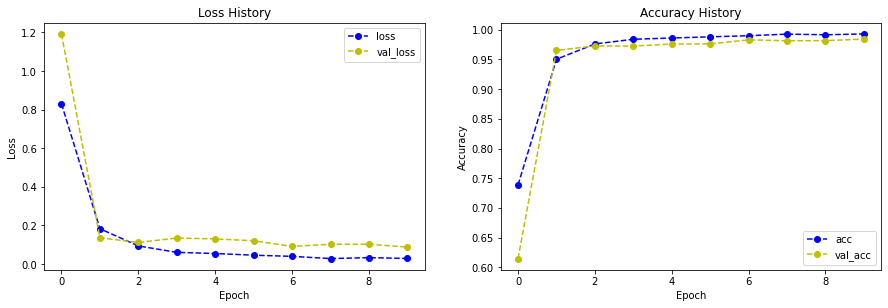

In [16]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Loss History')
plt.plot(history.history['loss'], '--bo',label='loss')
plt.plot(history.history['val_loss'], '--yo',label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.title('Accuracy History')
plt.plot(history.history['accuracy'], '--bo',label='acc')
plt.plot(history.history['val_accuracy'], '--yo',label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
import seaborn as sns

In [18]:
y_true = test_label

In [19]:
y_pred = model.predict(test_data)

In [20]:
y_pred = y_pred.argmax(axis=1)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.99      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

MCC :98.24


<AxesSubplot:>

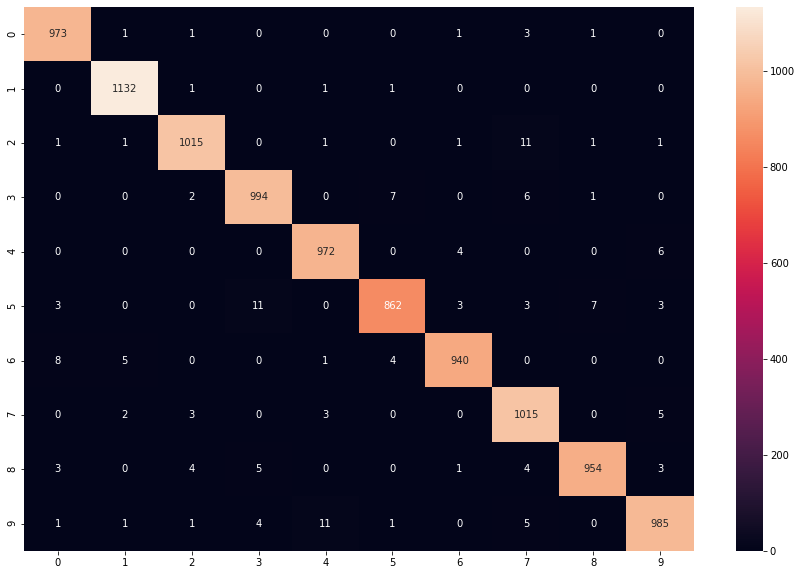

In [21]:
print(classification_report(y_true, y_pred))
print('MCC :{}'.format(round(matthews_corrcoef(y_true, y_pred) * 100, 2)))
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 10))
sns.heatmap(
    conf_mat, annot=True, fmt=''
)